In [1]:
# Import libraries
import matplotlib.pyplot as plt
from scipy.signal import resample
from scipy.io import readsav
import numpy as np
from ipywidgets import interact
from matplotlib.gridspec import GridSpec
from math import ceil

In [2]:
# System parameters
PRF = 3300 # pulse repetition frequency [Hz] (inverse of PRI)
L_a = 4.8 # antenna length [m]
# Doppler bandwidth depends on the antenna length and satellite velocity
pbw = 2800 # processed Doppler bandwidth [Hz]
Br = 100e6 # Chirp bandwidth in range [Hz]
Fr = 1.1*Br # Sampling frequency in range [Hz]

In [3]:
# Read the sav data 
data = readsav('compl_refl_city.sav')

In [4]:
complex_refl = data["compl_refl"]
complex_refl = complex_refl.astype(np.complex128)  # The data are complex

n_rg =complex_refl.shape[1] # Nunmber of samples in range 
n_az =complex_refl.shape[0] # Nunmber of samples in azimuth 
print(f"{n_az} x {n_rg} samples")

4096 x 4096 samples


# Energy of the signal

By Parseval's theorem, the energy of a signal can be calculated in the time domain or in the frequency domain. In the time domain, the energy of a signal is given by the sum of the square of the signal values. In the frequency domain, the energy of a signal is given by the sum of the square of the Fourier coefficients.

When applying the DFT to a signal, the transformation is normalized by $1/N$, where $N$ is the number of samples in the signal. This normalization factor is used to ensure that Parseval's theorem holds. The energy of the signal in the frequency domain is given by the sum of the square of the Fourier coefficients divided by $N$. This is the energy spectral density of the signal.

Mathematically, the energy of the 2D signal $x[i,j]$ is given by:

$$\begin{align*}
E &= \sum_{i=0}^{M-1} \sum_{j=0}^{N-1} |x[i,j]|^2 \\
&= \frac{1}{M} \sum_{i=0}^{M-1} \sum_{j=0}^{N-1} |X_{d_0}[i,j]|^2 \\
&= \frac{1}{N} \sum_{j=0}^{N-1} \sum_{i=0}^{M-1} |X_{d_1}[i,j]|^2 \\
&= \frac{1}{M N} \sum_{i=0}^{M-1} \sum_{j=0}^{N-1} |X[i,j]|^2
\end{align*}$$

where $M$ and $N$ are the number of rows and columns in the discrete signal, respectively, 
$X_{d_0}[i,j]$ is the DFT of the signal $x[i,j]$ along the first dimension,
$X_{d_1}[i,j]$ is the DFT of the signal $x[i,j]$ along the second dimension,
and $X[i,j]$ is the 2D DFT of the signal $x[i,j]$.

In [5]:
energy_in = np.sum(np.abs(complex_refl)**2)

In [6]:
from numpy.fft import fft, ifft, fftshift

In [7]:
s_1 = fftshift(fft(complex_refl, axis=0), axes=0) # azimuth fft

Text(0.5, 1.0, 'Azimuth FFT')

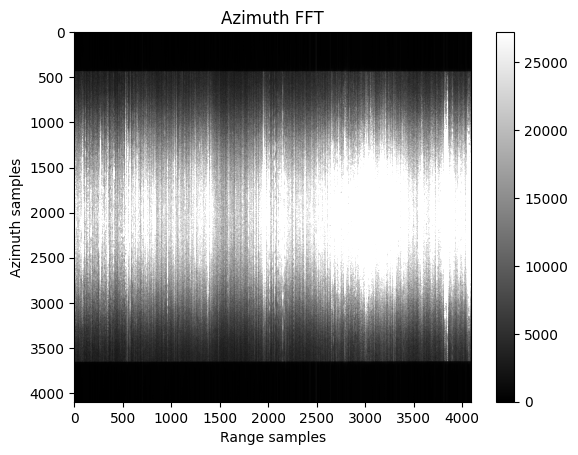

In [8]:
# Mean value of the amplitude
mean_value_s_1 = np.mean(np.abs(s_1))

plt.figure()
plt.imshow(np.abs(s_1),vmin=0,vmax=2*mean_value_s_1,aspect="auto",cmap="gray")
plt.xlabel("Range samples")
plt.ylabel("Azimuth samples")
plt.colorbar()
plt.title("Azimuth FFT")

In [9]:
def f2i(bw, data_bw, N):
    """
    Maps a frequency bandwith `bw` to a pair of indices in the zero-centered FFT array
    
    bw: bandwidth [Hz]
    data_bw: bandwidth of the data [Hz]
    N: number of samples
    
    Returns: (i0, i1) indices
    """
    r = int(N*bw/(2*data_bw))
    return (N//2-r, N//2+r)

# Part 1: Reduce the resolution

By looking at the FFT of the signal along the azimuth axis, we see that it is band-limited (up to a good approximation). This means that we can reduce the resolution of the signal without losing much information. This is done by keeping only the low-frequency components of the signal. This is equivalent to keeping only the low-frequency components of the FFT of the signal.

- We first perform the FFT of the signal along the azimuth axis (axis 0).
- We then keep only the low-frequency components of the FFT by multiplying it by 0 outside a certain range of frequencies (given by $(i_0, i_1$)).
- We then perform the inverse FFT to obtain the reduced-resolution signal.

Keep in mind that we are not downsampling the signal here, we are only reducing its resolution.

In [10]:
def plot_restricted_bandwidth_azimuth(pbw, data, prf):
    n_az = data.shape[0]
    i0, i1 = f2i(pbw, prf, n_az)
    data_cp = data.copy()
    data_cp[:i0] = 0
    data_cp[i1:] = 0
    # Frequency plot
    fig, axs = plt.subplots(1, 2, layout='constrained')
    # increase figure size
    fig.set_size_inches(18, 10)
    f_dopp = np.linspace(-prf/2,prf/2,n_az)
    axs[0].plot(f_dopp, np.abs(data_cp[:,0]))
    axs[0].axvline(x=-pbw/2,color="red")
    axs[0].axvline(x=pbw/2,color="red")
    axs[0].set_xlabel("Doppler frequency [Hz]")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid()
    axs[0].set_title(f"Limiting to {pbw} Hz of pbw")
    secax = axs[0].secondary_xaxis(-0.1, functions=(lambda x: (x/prf+1/2)*n_az, lambda x: x))
    secax.set_xlabel("Sample index ($k$)")

    # Reconstruct the image with the inverse FFT
    rc = np.fft.ifft(data_cp, axis=0)
    # Mean value of the amplitude
    mean_value_rc = np.mean(np.abs(rc))

    # 2d plot
    axs[1].imshow(np.abs(rc),vmin=0,vmax=2*mean_value_rc,aspect="auto",cmap="gray")
    axs[1].set_xlabel("Range samples")
    axs[1].set_ylabel("Azimuth samples")
    # set image to square aspect ratio
    axs[1].set_aspect('equal')
    plt.show()

In [11]:
interact(lambda pbw: plot_restricted_bandwidth_azimuth(pbw, s_1, PRF), pbw=(100, 3000, 100))

interactive(children=(IntSlider(value=1500, description='pbw', max=3000, min=100, step=100), Output()), _dom_c…

<function __main__.<lambda>(pbw)>

We can also do the same along the range axis (axis 1). In this case, instead of `pbw` (processed doppler bandwidth), we use `rbw` (range bandwidth).

In the following code, we have sliders for both `pbw` and `rbw`. We can change the values of these sliders to see the effect of reducing the resolution of the signal along the azimuth and range axes.

In [12]:
def plot_restricted_bandwidth(pbw, rbw, prf, rsf, complex_reflectance):
    s1 = fftshift(fft(complex_reflectance, axis=0), axes=0)
    n_az = s1.shape[0]
    n_rg = s1.shape[1]
    # Get min, max indices of processed Doppler bandwidth
    # everything outside of this range is set to zero
    i0, i1 = f2i(pbw, prf, n_az)
    s1[:i0] = 0
    s1[i1:] = 0
    # normalize the energy
    energy_s1 = np.sum(np.abs(s1)**2) / n_az
    s1 *= np.sqrt(energy_in/energy_s1)
    fig = plt.figure(layout='constrained')
    # increase figure size
    fig.set_size_inches(9, 12)
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 2])
    # Frequency plot in azimuth frequency samples
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, :])

    # plot in azimuth frequency samples
    f_dopp = np.linspace(-prf/2,prf/2,n_az)
    ax0.plot(f_dopp, np.abs(s1[:,0]))
    ax0.axvline(x=-pbw/2,color="red")
    ax0.axvline(x=pbw/2,color="red")
    ax0.set_xlabel("Doppler frequency [Hz]")
    ax0.set_ylabel("Amplitude")
    ax0.grid()
    ax0.set_title(f"Limiting to {pbw} Hz of pbw")
    secax = ax0.secondary_xaxis(-0.2, functions=(lambda x: (x/prf+1/2)*n_az, lambda x: x))
    secax.set_xlabel("Sample index ($k$)")

    az_compressed_data = ifft(s1, axis=0)
    # Range compression
    s2 = fftshift(fft(az_compressed_data, axis=1), axes=1)
    
    j0, j1 = f2i(rbw, rsf, n_rg)
    s2[:, :j0] = 0
    s2[:, j1:] = 0
    # normalize the energy
    energy_s2 = np.sum(np.abs(s2)**2) / n_rg
    s2 *= np.sqrt(energy_in/energy_s2)
    f_rg = np.linspace(-rsf/2,rsf/2,n_rg)
    # plot in range frequency samples
    ax1.plot(f_rg, np.abs(s2[0]))
    ax1.axvline(x=-rbw/2,color="red")
    ax1.axvline(x=rbw/2,color="red")
    ax1.set_xlabel("Range frequency [Hz]")
    ax1.set_ylabel("Amplitude")
    ax1.grid()
    ax1.set_title(f"Limiting to {round(rbw/1e6)} MHz of rbw")
    secax = ax1.secondary_xaxis(-0.2, functions=(lambda x: (x/rsf+1/2)*n_rg, lambda x: x))
    secax.set_xlabel("Sample index ($k$)")

    # Reconstruct the image with the inverse FFT
    rc = ifft(s2, axis=1)
    # Mean value of the amplitude
    mean_value_rc = np.mean(np.abs(rc))

    # 2d plot
    img = ax2.imshow(np.abs(rc),vmin=0,vmax=2*mean_value_rc,aspect="equal",cmap="gray")
    ax2.set_xlabel("Range samples")
    ax2.set_ylabel("Azimuth samples")
    fig.colorbar(img, ax=ax2, orientation='vertical')
    plt.show()
    print(f"Energy in: {energy_in}, Energy out: {np.sum(np.abs(rc)**2)}")

In [13]:
interact(lambda pbw, rbw: plot_restricted_bandwidth(pbw, rbw, PRF, Fr, complex_refl), pbw=(100, 3000, 100), rbw=(10e6, 100e6, 10e6))

interactive(children=(IntSlider(value=1500, description='pbw', max=3000, min=100, step=100), FloatSlider(value…

<function __main__.<lambda>(pbw, rbw)>

# Bonus: downsampling the signal

To reduce the resolution of the signal, we can also downsample it. This is done using `scipy.signal.resample` with a carefully chosen number of points. In this case, we choose a number of points $M^\ast$ such that only the frequencies in the chosen processed doppler bandwidth (`pbw`) are kept:

$$M^\ast = \left \lceil M \cdot \frac{\text{pbw}}{\text{PRF}} \right \rceil$$

In [18]:
pbw = 2600 # processed Doppler bandwidth [Hz]
# we'll downsample the data using the scipy resample function
# the new number of samples is given by the formula:
n_az_new = ceil(n_az * pbw / PRF)
print(f"New number of samples: {n_az_new}")

New number of samples: 3228


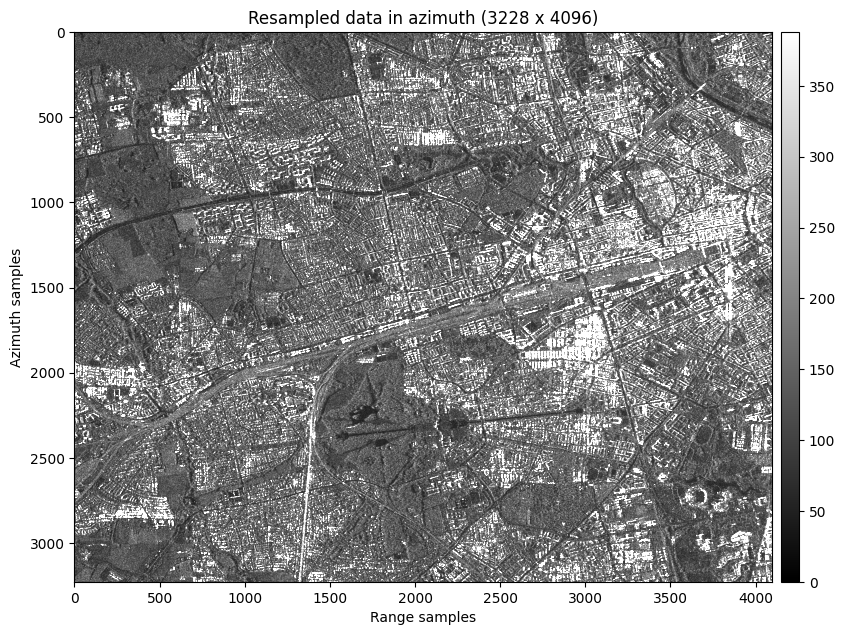

In [15]:
complex_refl_resampled = resample(complex_refl, n_az_new, axis=0)
# energy normalization
energy_resampled = np.sum(np.abs(complex_refl_resampled)**2)
complex_refl_resampled *= np.sqrt(energy_in/energy_resampled)
mean_value_rs = np.mean(np.abs(complex_refl_resampled))
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
img = ax.imshow(np.abs(complex_refl_resampled),vmin=0,vmax=2*mean_value_rs,aspect="equal",cmap="gray")
ax.set_xlabel("Range samples")
ax.set_ylabel("Azimuth samples")
ax.set_title(f"Resampled data in azimuth ({n_az_new} x {n_rg})")
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(img, cax=cax)
plt.show()

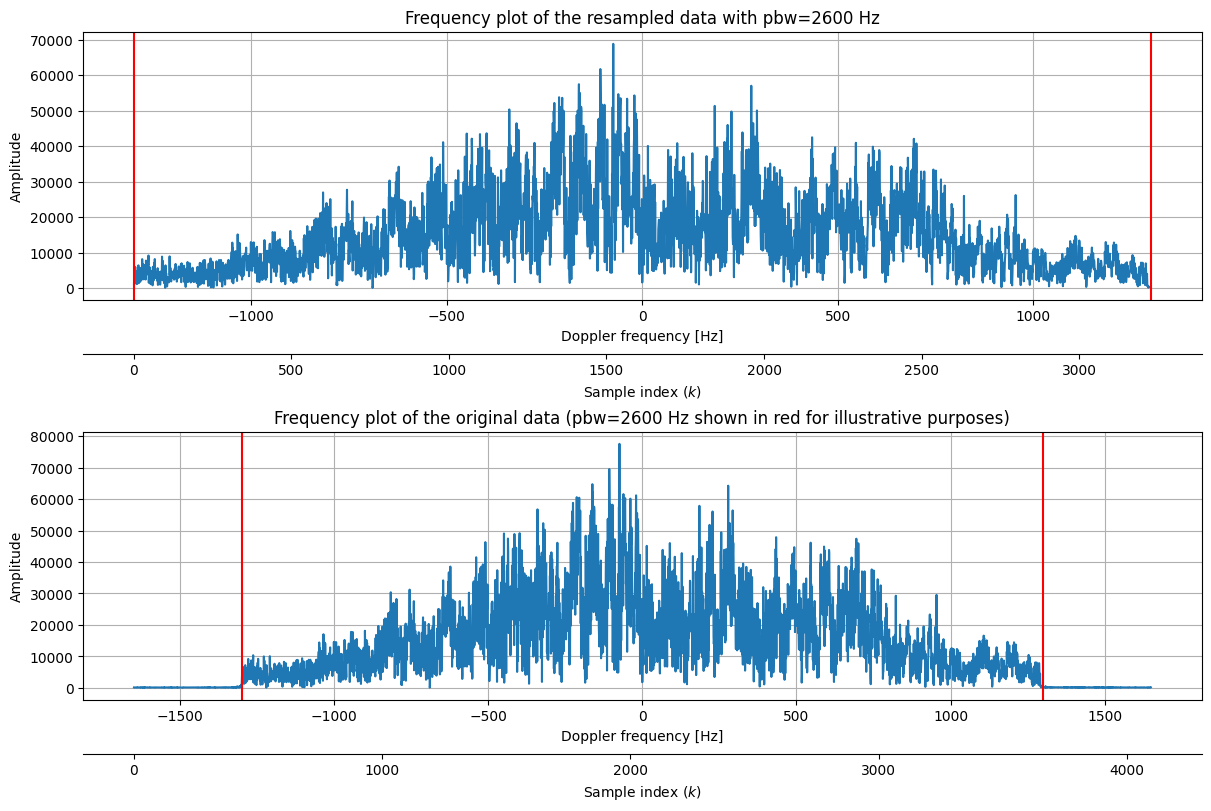

In [16]:
s_1_resampled = fftshift(fft(complex_refl_resampled, axis=0), axes=0)
f_dopp_rs = np.linspace(-pbw/2,pbw/2,n_az_new)
# plot
fig, axs = plt.subplots(2, 1, layout='constrained')
fig.set_size_inches(12, 8)
axs[0].plot(f_dopp_rs, np.abs(s_1_resampled[:,0]))
axs[0].axvline(x=-pbw/2,color="red")
axs[0].axvline(x=pbw/2,color="red")
axs[0].set_xlabel("Doppler frequency [Hz]")
axs[0].set_ylabel("Amplitude")
axs[0].set_title(f"Frequency plot of the resampled data with pbw={pbw} Hz")
secax = axs[0].secondary_xaxis(-0.2, functions=(lambda x: (x/pbw+1/2)*n_az_new, lambda x: x))
secax.set_xlabel("Sample index ($k$)")
axs[0].grid()
# plot original data
f_dopp = np.linspace(-PRF/2,PRF/2,n_az)
axs[1].plot(f_dopp, np.abs(s_1[:,0]))
axs[1].axvline(x=-pbw/2,color="red")
axs[1].axvline(x=pbw/2,color="red")
axs[1].set_xlabel("Doppler frequency [Hz]")
axs[1].set_ylabel("Amplitude")
axs[1].set_title(f"Frequency plot of the original data (pbw={pbw} Hz shown in red for illustrative purposes)")
secax = axs[1].secondary_xaxis(-0.2, functions=(lambda x: (x/PRF+1/2)*n_az, lambda x: x))
secax.set_xlabel("Sample index ($k$)")
axs[1].grid()

Text(0.5, 1.0, 'Azimuth FFT of resampled data')

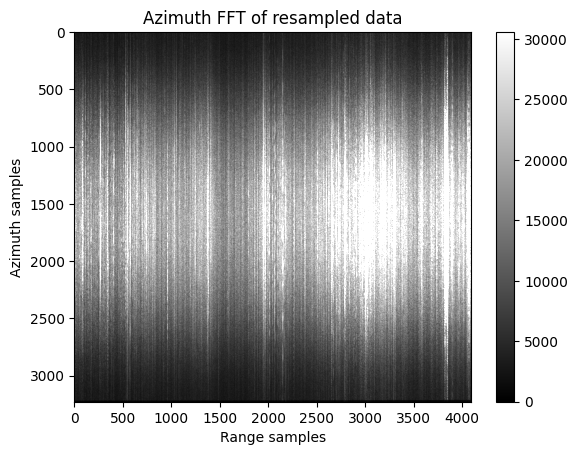

In [17]:
plt.figure()
plt.imshow(np.abs(s_1_resampled),vmin=0,vmax=2*np.mean(np.abs(s_1_resampled)),aspect="auto",cmap="gray")
plt.xlabel("Range samples")
plt.ylabel("Azimuth samples")
plt.colorbar()
plt.title("Azimuth FFT of resampled data")